<a href="https://colab.research.google.com/github/aldebaro/ai6g/blob/main/10_channel_estimation_using_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G**.
*Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

Original code from https://github.com/YudiDong/Channel_Estimation_cGAN/
This repository above describes the implementation of the paper: 
Yudi Dong, Huaxia Wang, and Yu-Dong Yao, “Channel Estimation for One-Bit Multiuser Massive MIMO Using Conditional GAN.” ArXiv:2006.11435 [Eess], June 2020. arXiv.org, http://arxiv.org/abs/2006.11435.
IEEE Communications Letters, 2020.

In [ ]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    %cd ai6g
    !ln -s /content/drive/MyDrive/ai6g_files/files_10_channel/* ./files_10_channel
    !pip install -r requirements.txt

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from files_10_channel.GAN.cGANGenerator import Generator
from files_10_channel.GAN.cGANDiscriminator import Discriminator
from files_10_channel.GAN.data_preprocess import load_image_train, load_image_test, load_image_test_y
from tempfile import TemporaryFile
from scipy.io import loadmat, savemat
import datetime
import h5py
#import hdf5storage
#import skfuzzy as fuzz
from scipy.linalg import norm

In [2]:
%matplotlib inline
#plot inside Jupyter notebook
#Read more at https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline

In [3]:
# GPU Setting
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.enable_eager_execution(config=config)
layers = tf.keras.layers

In [4]:
# data path
#path = "../Data_Generation/Gan_Data/Gan_0_dBIndoor2p4_64ant_32users_8pilot.mat" #original path
path = "./files_10_channel/cgan_data/Gan_0_dBIndoor2p4_64ant_32users_8pilot.mat"

# batch = 1 produces good results on U-NET
BATCH_SIZE = 1              

In [5]:
# model
generator = Generator()
discriminator = Discriminator()
# optimizer
generator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.compat.v1.train.RMSPropOptimizer(2e-5)
#discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)

In [6]:
'''
Average NMSE as Frobenius norms.
Calculate for a 4D tensor such as
(664, 64, 32, 2)
by first converting the matrices into complex-valued matrices.
Aldebaro, Sep. 2022
'''
def nmse_average(y_true, y_pred):
    num_matrices, N, M, realimag = y_true.shape
    assert(realimag == 2)
    all_nmses = np.zeros(num_matrices,)
    for i in range(num_matrices):
        #convert to complex matrices
        true_matrix = np.empty( (N,M), dtype=np.complex128)
        true_matrix.real = y_true[i,:,:,0]
        true_matrix.imag = y_true[i,:,:,1]

        pred_matrix = np.empty( (N,M), dtype=np.complex128)
        pred_matrix.real = y_pred[i,:,:,0]
        pred_matrix.imag = y_pred[i,:,:,1]

        error = true_matrix - pred_matrix
        numerator = norm(error, ord='fro') ** 2
        denominator = norm(true_matrix, ord='fro') ** 2
        if denominator == 0 and numerator == 0:
            all_nmses[i] = 0
        else:
            all_nmses[i] = numerator / denominator
    return np.mean(all_nmses)

In [7]:
"""
Discriminator loss:
The discriminator loss function takes 2 inputs; real images, generated images
real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since the real images)
generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since the fake images)
Then the total_loss is the sum of real_loss and the generated_loss
"""
def discriminator_loss(disc_real_output, disc_generated_output):
    """disc_real_output = [real_target]
       disc_generated_output = [generated_target]
    """
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(disc_real_output), logits=disc_real_output)  # label=1
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(disc_generated_output), logits=disc_generated_output)  # label=0
    total_disc_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    return total_disc_loss


In [8]:
"""
Generator loss:
It is a sigmoid cross entropy loss of the generated images and an array of ones.
The paper also includes L2 loss between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss = gan_loss + LAMBDA * l2_loss, where LAMBDA = 100. 
This value was decided by the authors of the paper.
"""
def generator_loss(disc_generated_output, gen_output, target, l2_weight=100):
    """
        disc_generated_output: output of Discriminator when input is from Generator
        gen_output:  output of Generator (i.e., estimated H)
        target:  target image
        l2_weight: weight of L2 loss
    """
    # GAN loss
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(disc_generated_output), logits=disc_generated_output)
    # L2 loss
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = tf.reduce_mean(gen_loss) + l2_weight * l2_loss
    return total_gen_loss

In [9]:
def generated_image(model, test_input, tar, t=0):
    """Dispaly  the results of Generator"""
    prediction = model(test_input)
    #plt.figure(figsize=(15, 15))
    display_list = [np.squeeze(test_input[:,:,:,0]), np.squeeze(tar[:,:,:,0]), np.squeeze(prediction[:,:,:,0])]
    

    title = ['Input Y', 'Target H', 'Prediction H']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]) 
        plt.axis("off")
    plt.savefig(os.path.join("generated_img", "img_"+str(t)+".png"))

In [10]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image)                      # input -> generated_target
        disc_real_output = discriminator(target)  # [input, target] -> disc output
        disc_generated_output = discriminator(gen_output)  # [input, generated_target] -> disc output
        # print("*", gen_output.shape, disc_real_output.shape, disc_generated_output.shape)

        # calculate loss
        gen_loss = generator_loss(disc_generated_output, gen_output, target)   # gen loss
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)  # disc loss

    # gradient
    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # apply gradient
    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [11]:
def train(epochs):
    nm = []
    ep = []
    start_time = datetime.datetime.now()
    for epoch in range(epochs):
        print("-----\nEPOCH:", epoch)
        # train
        for bi, (target, input_image) in enumerate(load_image_train(path)):
            elapsed_time = datetime.datetime.now() - start_time
            gen_loss, disc_loss = train_step(input_image, target)
            print("Batch/Epoch:", bi, '/' , epoch, ", Generator loss:", gen_loss.numpy(), ", Discriminator loss:", disc_loss.numpy(), ', time:',  elapsed_time)
            #AK
            #if bi > 10:
            #    break
        # generated and see the progress
        for bii, (tar, inp) in enumerate(load_image_test(path)):            
            if bii == 100:
                generated_image(generator, inp, tar, t=epoch+1  )

        # save checkpoint
        # if (epoch + 1) % 2 == 0:
        ep.append(epoch + 1)
        #generator.save_weights(os.path.join(BASE_PATH, "weights/generator_"+str(epoch)+".h5"))
        #discriminator.save_weights(os.path.join(BASE_PATH, "weights/discriminator_"+str(epoch)+".h5"))
        
        realim, inpuim = load_image_test_y(path)   
        prediction = generator(inpuim)
        
        #AK
        #nm.append(fuzz.average_nmse(np.squeeze(realim), np.squeeze(prediction)))
        nm.append(nmse_average(np.squeeze(realim), np.squeeze(prediction)))
        
        if epoch == epochs-1:
            nmse_epoch = TemporaryFile()
            np.save(nmse_epoch, nm)
        
        # Save the predicted Channel 
        matfiledata = {} # make a dictionary to store the MAT data in
        matfiledata[u'predict_Gan_0_dB_Indoor2p4_64ant_32users_8pilot'] = np.array(prediction) # *** u prefix for variable name = unicode format, no issues thru Python 3.5; advise keeping u prefix indicator format based on feedback despite docs ***
        #hdf5storage.write(matfiledata, '.', 'Results\Eest_cGAN_'+str(epoch + 1)+'_0db_Indoor2p4_64ant_32users_8pilot.mat', matlab_compatible=True)
        
        if False:
            plt.figure()
            plt.plot(ep,nm,'^-r')
            plt.xlabel('Epoch')
            plt.ylabel('NMSE')
            plt.show();
    
    return nm, ep

-----
EPOCH: 0
Batch/Epoch: 0 / 0 , Generator loss: 60.316246 , Discriminator loss: 1.3874917 , time: 0:00:00.037897
Batch/Epoch: 1 / 0 , Generator loss: 59.68959 , Discriminator loss: 1.387989 , time: 0:00:07.376702
Batch/Epoch: 2 / 0 , Generator loss: 60.363815 , Discriminator loss: 1.3868561 , time: 0:00:07.539037
Batch/Epoch: 3 / 0 , Generator loss: 58.72411 , Discriminator loss: 1.3867085 , time: 0:00:07.700752
Batch/Epoch: 4 / 0 , Generator loss: 58.08365 , Discriminator loss: 1.387644 , time: 0:00:07.860328
Batch/Epoch: 5 / 0 , Generator loss: 59.343224 , Discriminator loss: 1.3870995 , time: 0:00:08.021952
Batch/Epoch: 6 / 0 , Generator loss: 58.43833 , Discriminator loss: 1.3877201 , time: 0:00:08.183464
Batch/Epoch: 7 / 0 , Generator loss: 59.23421 , Discriminator loss: 1.3857973 , time: 0:00:08.344078
Batch/Epoch: 8 / 0 , Generator loss: 60.30627 , Discriminator loss: 1.3870388 , time: 0:00:08.505603
Batch/Epoch: 9 / 0 , Generator loss: 60.512455 , Discriminator loss: 1.3875

Batch/Epoch: 80 / 0 , Generator loss: 36.659016 , Discriminator loss: 1.3829944 , time: 0:00:20.296250
Batch/Epoch: 81 / 0 , Generator loss: 36.10641 , Discriminator loss: 1.3851666 , time: 0:00:20.455155
Batch/Epoch: 82 / 0 , Generator loss: 33.085648 , Discriminator loss: 1.3854561 , time: 0:00:20.614169
Batch/Epoch: 83 / 0 , Generator loss: 35.08235 , Discriminator loss: 1.3845623 , time: 0:00:20.776236
Batch/Epoch: 84 / 0 , Generator loss: 33.60189 , Discriminator loss: 1.385317 , time: 0:00:20.935378
Batch/Epoch: 85 / 0 , Generator loss: 31.869806 , Discriminator loss: 1.3844669 , time: 0:00:21.097236
Batch/Epoch: 86 / 0 , Generator loss: 30.237343 , Discriminator loss: 1.3851749 , time: 0:00:21.257516
Batch/Epoch: 87 / 0 , Generator loss: 31.267702 , Discriminator loss: 1.387356 , time: 0:00:21.417260
Batch/Epoch: 88 / 0 , Generator loss: 36.31647 , Discriminator loss: 1.3879606 , time: 0:00:21.575832
Batch/Epoch: 89 / 0 , Generator loss: 34.50454 , Discriminator loss: 1.3852893 

Batch/Epoch: 6 / 1 , Generator loss: 26.350533 , Discriminator loss: 1.3816946 , time: 0:00:34.406770
Batch/Epoch: 7 / 1 , Generator loss: 32.899643 , Discriminator loss: 1.3789756 , time: 0:00:34.565321
Batch/Epoch: 8 / 1 , Generator loss: 34.815166 , Discriminator loss: 1.378186 , time: 0:00:34.723937
Batch/Epoch: 9 / 1 , Generator loss: 28.153986 , Discriminator loss: 1.3810728 , time: 0:00:34.882474
Batch/Epoch: 10 / 1 , Generator loss: 33.911945 , Discriminator loss: 1.3762538 , time: 0:00:35.042081
Batch/Epoch: 11 / 1 , Generator loss: 32.053196 , Discriminator loss: 1.3771514 , time: 0:00:35.204613
Batch/Epoch: 12 / 1 , Generator loss: 33.51436 , Discriminator loss: 1.376061 , time: 0:00:35.363199
Batch/Epoch: 13 / 1 , Generator loss: 28.608067 , Discriminator loss: 1.3801572 , time: 0:00:35.523964
Batch/Epoch: 14 / 1 , Generator loss: 35.75014 , Discriminator loss: 1.3776048 , time: 0:00:35.683034
Batch/Epoch: 15 / 1 , Generator loss: 28.871748 , Discriminator loss: 1.378077 , 

Batch/Epoch: 86 / 1 , Generator loss: 34.532806 , Discriminator loss: 1.1392593 , time: 0:00:47.245535
Batch/Epoch: 87 / 1 , Generator loss: 33.466343 , Discriminator loss: 1.1026995 , time: 0:00:47.403923
Batch/Epoch: 88 / 1 , Generator loss: 35.574722 , Discriminator loss: 1.1145604 , time: 0:00:47.564121
Batch/Epoch: 89 / 1 , Generator loss: 34.200523 , Discriminator loss: 1.0989624 , time: 0:00:47.722706
Batch/Epoch: 90 / 1 , Generator loss: 29.78461 , Discriminator loss: 1.1382211 , time: 0:00:47.882013
Batch/Epoch: 91 / 1 , Generator loss: 34.876137 , Discriminator loss: 1.084928 , time: 0:00:48.040270
Batch/Epoch: 92 / 1 , Generator loss: 32.45695 , Discriminator loss: 1.0887117 , time: 0:00:48.201842
Batch/Epoch: 93 / 1 , Generator loss: 29.188702 , Discriminator loss: 1.1644825 , time: 0:00:48.360112
Batch/Epoch: 94 / 1 , Generator loss: 30.23494 , Discriminator loss: 1.0820928 , time: 0:00:48.519606
Batch/Epoch: 95 / 1 , Generator loss: 31.96641 , Discriminator loss: 1.039838

Batch/Epoch: 11 / 2 , Generator loss: 34.914154 , Discriminator loss: 0.2134228 , time: 0:01:00.227850
Batch/Epoch: 12 / 2 , Generator loss: 31.68418 , Discriminator loss: 0.2714193 , time: 0:01:00.387445
Batch/Epoch: 13 / 2 , Generator loss: 29.330093 , Discriminator loss: 0.30655587 , time: 0:01:00.547083
Batch/Epoch: 14 / 2 , Generator loss: 28.535908 , Discriminator loss: 0.33818612 , time: 0:01:00.708665
Batch/Epoch: 15 / 2 , Generator loss: 29.27991 , Discriminator loss: 0.28728506 , time: 0:01:00.869272
Batch/Epoch: 16 / 2 , Generator loss: 31.304268 , Discriminator loss: 0.28151393 , time: 0:01:01.026804
Batch/Epoch: 17 / 2 , Generator loss: 35.45731 , Discriminator loss: 0.19902945 , time: 0:01:01.190367
Batch/Epoch: 18 / 2 , Generator loss: 33.69579 , Discriminator loss: 0.21019569 , time: 0:01:01.353900
Batch/Epoch: 19 / 2 , Generator loss: 35.178673 , Discriminator loss: 0.1782992 , time: 0:01:01.515433
Batch/Epoch: 20 / 2 , Generator loss: 28.030304 , Discriminator loss: 0

Batch/Epoch: 92 / 2 , Generator loss: 38.147045 , Discriminator loss: 0.2672795 , time: 0:01:13.359166
Batch/Epoch: 93 / 2 , Generator loss: 38.562626 , Discriminator loss: 0.8608453 , time: 0:01:13.518117
Batch/Epoch: 94 / 2 , Generator loss: 41.41567 , Discriminator loss: 0.14300206 , time: 0:01:13.674027
Batch/Epoch: 95 / 2 , Generator loss: 35.790096 , Discriminator loss: 0.17051119 , time: 0:01:13.831661
Batch/Epoch: 96 / 2 , Generator loss: 39.937046 , Discriminator loss: 0.21790257 , time: 0:01:13.991594
Batch/Epoch: 97 / 2 , Generator loss: 32.256042 , Discriminator loss: 1.9208757 , time: 0:01:14.151634
Batch/Epoch: 98 / 2 , Generator loss: 36.62108 , Discriminator loss: 0.22492768 , time: 0:01:14.311120
Batch/Epoch: 99 / 2 , Generator loss: 36.477882 , Discriminator loss: 0.08610853 , time: 0:01:14.469674
Batch/Epoch: 100 / 2 , Generator loss: 37.58007 , Discriminator loss: 0.10966139 , time: 0:01:14.627928
Batch/Epoch: 101 / 2 , Generator loss: 34.48937 , Discriminator loss:

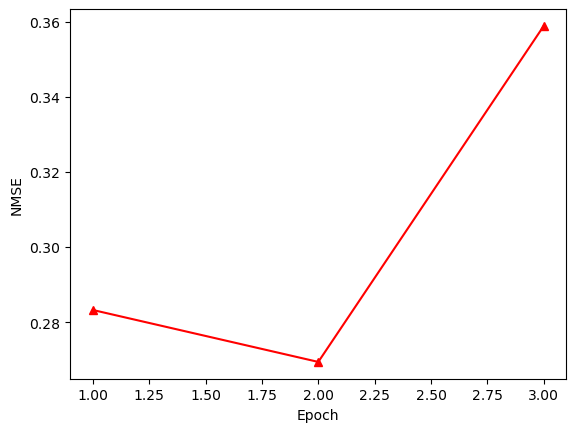

In [12]:
#Execute the training routine
number_of_epochs = 2
nm, ep = train(epochs=number_of_epochs)
if True: #enable to plot NMSE over epochs
    plt.figure()
    plt.plot(ep,nm,'^-r')
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.show();

## Authors

- [Marcos Yuichi Takeda - LASSE/UFPA](https://github.com/yuichitakeda)